# EDA

## Table of contents
1. [Training/Weather Data](#train)
2. [Timewise Trend of Mosquitoes](#timetrend)
3. [WNV Distribution in Species](#wnvspeciesdistn)
4. [Overall Rate of WNV Infection](#ratewnv)
4. [Spraying Data](#spray)
5. [Important Traps](#import_traps)

## Imports

In [1]:
import pandas as pd
import numpy as np
import matplotlib.pyplot as plt
import seaborn as sns
import math
import datetime as dt
import re


In [2]:
# Reading in the data
test_clean = pd.read_csv('../data/test_clean.csv')
train_clean = pd.read_csv('../data/train_clean.csv')
weather_clean = pd.read_csv('../data/weather_clean.csv')
spray_clean = pd.read_csv('../data/spray_clean.csv')

## Training/Weather Data<a name=train></a>
---

In [3]:
#function to convert coordinates to radians before calculating distance between 2 coordinates
def get_distance(lat1, lon1, lat2, lon2):
    """
    This function takes the latitudes and longitudes of two points and returns the distance between them in km where:
    - lat1: the latitude of the first point
    - lon1: the longitude of the first point
    - lat2: the latitude of the second point
    - lon2: the longitude of the second point
    - R: the radius of the Earth in km
    - C: the central angle between the two points in radians
    - temp: a temporary variable to account for 3 dimensionality
    """
    R = 6373.0
    lat1, lon1, lat2, lon2 = map(math.radians, [lat1, lon1, lat2, lon2])
    dlon = lon2 - lon1
    dlat = lat2 - lat1
    temp = (
         math.sin(dlat / 2) ** 2
       + math.cos(lat1)
       * math.cos(lat2)
       * math.sin(dlon / 2) ** 2
    )
    C = (2 * math.atan2(math.sqrt(temp), math.sqrt(1 - temp)))
    distance = R * C
    return distance

#function to calculate nearest station from trap according to distance
def nearest_station(trap_lat, trap_lon):
    """
    This function takes the latitude and longitude of a point (trap) and returns the station that the point is closer to 
    (station 1 or station 2)
    - trap_lat: the latitude of the trap
    - trap_lon: the longitude of the trap
    - station1_lat: the latitude of station 1 = 41.995
    - station1_lon: the longitude of station 1= -87.933
    - station2_lat: the latitude of station 2 = 41.786
    - station2_lon: the longitude of station 2 = -87.752
    - dist_station1: the distance to station 1
    - dist_station2: the distance to station 2
    """
    station1_lat = 41.995
    station1_lon = -87.933
    station2_lat = 41.786
    station2_lon = -87.752
    #calculates trap distance with station 1 / 2
    dist_station1 = get_distance(station1_lat,station1_lon,trap_lat,trap_lon)
    dist_station2 = get_distance(station2_lat,station2_lon,trap_lat,trap_lon)
    #comparing distances
    if dist_station1 > dist_station2:
        return 2
    else:
        return 1

In [4]:
# creating new columns for training and testing sets to assign each sample collection to either 1 or 2 based on proximity
# to be used for plotting locations further on
train_clean['station'] = train_clean.apply(lambda x: nearest_station(x.latitude,x.longitude), axis = 1)
test_clean['station'] = test_clean.apply(lambda x: nearest_station(x.latitude,x.longitude), axis = 1)
spray_clean['station'] = test_clean.apply(lambda x: nearest_station(x.latitude,x.longitude), axis = 1)

# reverting the dates on all dataframes to datetime
train_clean['date'] = pd.to_datetime(train_clean['date'])
test_clean['date'] = pd.to_datetime(test_clean['date'])
spray_clean['date'] = pd.to_datetime(spray_clean['date'])
weather_clean['date'] = pd.to_datetime(weather_clean['date'])

In [5]:
# Creating a merged dataset of weather and train dataframes
weather_train_df = pd.merge(train_clean, weather_clean, on =['station', 'year','date', 'month', 'week', 'weekday'])

In [6]:
# Creating a merged dataset of weather and spray dataframes
weather_spray_df = pd.merge(spray_clean, weather_clean, on =['station', 'year','date', 'month', 'week', 'weekday'])

In [7]:
# creating a new column 'wnv_mosqs' that calculates the number of mosquitoes with WNV
weather_train_df['wnv_mosqs'] = weather_train_df['wnvpresent'] * weather_train_df['nummosquitos']

In [8]:
# sanity check to ensure merge is successful
weather_train_df.shape

(9693, 34)

In [9]:
# checking the dataframe
weather_train_df.head()

,date,address,species,block,street,trap,addressnumberandstreet,latitude,longitude,addressaccuracy,...,sunrise,sunset,codesum,preciptotal,stnpressure,sealevel,resultspeed,resultdir,avgspeed,wnv_mosqs
0,2007-05-29,"4100 North Oak Park Avenue, Chicago, IL 60634,...",CULEX PIPIENS/RESTUANS,41,N OAK PARK AVE,T002,"4100 N OAK PARK AVE, Chicago, IL",41.954690,-87.800991,9,...,04:21:00,19:17:00,"['BR', 'HZ']",0.0,29.39,30.11,5.8,18,6.5,0
1,2007-05-29,"4100 North Oak Park Avenue, Chicago, IL 60634,...",CULEX RESTUANS,41,N OAK PARK AVE,T002,"4100 N OAK PARK AVE, Chicago, IL",41.954690,-87.800991,9,...,04:21:00,19:17:00,"['BR', 'HZ']",0.0,29.39,30.11,5.8,18,6.5,0
2,2007-05-29,"6200 North Mandell Avenue, Chicago, IL 60646, USA",CULEX RESTUANS,62,N MANDELL AVE,T007,"6200 N MANDELL AVE, Chicago, IL",41.994991,-87.769279,9,...,04:21:00,19:17:00,"['BR', 'HZ']",0.0,29.39,30.11,5.8,18,6.5,0
3,2007-05-29,"7900 West Foster Avenue, Chicago, IL 60656, USA",CULEX PIPIENS/RESTUANS,79,W FOSTER AVE,T015,"7900 W FOSTER AVE, Chicago, IL",41.974089,-87.824812,8,...,04:21:00,19:17:00,"['BR', 'HZ']",0.0,29.39,30.11,5.8,18,6.5,0
4,2007-05-29,"7900 West Foster Avenue, Chicago, IL 60656, USA",CULEX RESTUANS,79,W FOSTER AVE,T015,"7900 W FOSTER AVE, Chicago, IL",41.974089,-87.824812,8,...,04:21:00,19:17:00,"['BR', 'HZ']",0.0,29.39,30.11,5.8,18,6.5,0


From just looking at the head of our training data we can already tell that there are several instances of rows with exactly the same time and location values, but occaisonally different data values regarding sample collection i.e `species`, `nummosquitos`, `wnvpresent`, and `wnv_mosqs`. 

This is due to the event of multiple species of mosquitoes being identified when the trap is collected. Additionally, there is a max capacity of 50 mosquitos in each row, which results in an additional rows being created if a trap contains more than that amount. When including the requirement of the data further being split into rows if WNV is present in just some of the mosquitoes, a single trap instance can span up to 18 different rows.

In the interest of obtaining more accurate insights in our EDA, we will use a dataframe (`single_samples`) to accurately identify the number of traps lain.


In [10]:
# Getting all columns in our training data apart from 'species', 'nummosquitos', 'wnvpresent', and 'wnv_mosqs'
train_cols = [col for col in weather_train_df.columns if col not in ['species', 'nummosquitos', 'wnvpresent', 'wnv_mosqs']]

In [11]:
# Assigning the training data with no duplicates to single_samples
single_samples = weather_train_df.drop_duplicates(subset=train_cols)

In [12]:
 # Shape of single_samples
single_samples.shape

(4616, 34)

In [13]:
print(f'The number of tests performed in our training set is {single_samples.shape[0]}.')

The number of tests performed in our training set is 4616.


## Timewise Trends of Mosquitoes<a name=timetrend></a>

In [14]:
def timewise_trender(
    time_period,
    list_xticklabels):
    """
    This function takes in two arguments and produces four subplots depicting the timewise trend of 
    mosquito sample collection from our training data.
    - time_period: The time frame according to which we want to section our data e.g. year, month, week
    - list_xticklabels: The list of labels that we want to give our subplots
    """

    fig, axs = plt.subplots(2,2, figsize=(18,12))
    fig.tight_layout(pad=5)

    # plotting the number of WNV-infected mosquitoes by year
    axs[0][0].set_title(f'Total Number of Mosquitoes by {time_period.capitalize()}', fontsize=14)

    axs[0][0].bar(weather_train_df.groupby(f'{time_period}')['nummosquitos'].sum().reset_index().index,
    weather_train_df.groupby(f'{time_period}')['wnv_mosqs'].sum() 
              # / single_samples.groupby('year')['trap'].count()[single_samples.groupby('year')['wnv_mosqs'].mean() > 0]
               ,
        color='red',
        alpha=0.8, 
        label='WNV Mosquitos'
    )

    axs[0][0].bar(weather_train_df.groupby(f'{time_period}')['nummosquitos'].sum().reset_index().index,
    weather_train_df.groupby(f'{time_period}')['nummosquitos'].sum()
              # / single_samples.groupby('year')['trap'].count()[single_samples.groupby('year')['nummosquitos'].mean() > 0]
               ,
        color='#4986B6',
        alpha=0.5,               
        label='Total Mosquitos'
    )

    axs[0][0].set_xlabel(time_period.capitalize(), labelpad=10, fontsize=12)
    axs[0][0].set_xticks(ticks=weather_train_df.groupby(f'{time_period}')['nummosquitos'].sum().reset_index().index, 
               labels=list_xticklabels)
    axs[0][0].set_ylabel('Total Number of Mosquitoes', fontsize=12)

    axs[0][0].legend()

    # Plotting the number of traps per year
    axs[0][1].set_title(f'Number of Traps by {time_period.capitalize()}', fontsize=14)

    axs[0][1].bar(
        single_samples.groupby(by=f'{time_period}').sum().index,
        single_samples.groupby(f'{time_period}')['trap'].count(),
        color='#4986B6',
    )

    axs[0][1].set_xlabel(time_period.capitalize(), labelpad=10, fontsize=12)
    axs[0][1].set_xticks(ticks=train_clean.groupby(by=f'{time_period}').sum().index, 
               labels=list_xticklabels)
    axs[0][1].set_ylabel('Number of Traps', fontsize=12)


    # plotting the number of WNV-infected mosquitoes per trap by year
    axs[1][0].set_title(f'Total Number of Mosquitoes per Trap by {time_period.capitalize()}', fontsize=14)

    axs[1][0].bar(weather_train_df.groupby(f'{time_period}')['nummosquitos'].sum().reset_index().index,
    weather_train_df.groupby(f'{time_period}')['wnv_mosqs'].sum()
               / single_samples.groupby(f'{time_period}')['trap'].count()
               ,
        color='red',
        alpha=0.8, 
        label='WNV Mosquitos'
    )

    axs[1][0].bar(weather_train_df.groupby(f'{time_period}')['nummosquitos'].sum().reset_index().index,
    weather_train_df.groupby(f'{time_period}')['nummosquitos'].sum() 
               / single_samples.groupby(f'{time_period}')['trap'].count()
               ,
        color='#4986B6',
        alpha=0.5,               
        label='Total Mosquitos'
    )

    axs[1][0].set_xlabel(time_period.capitalize(), labelpad=10, fontsize=12)
    axs[1][0].set_xticks(ticks=weather_train_df.groupby(f'{time_period}')['nummosquitos'].sum().reset_index().index, 
               labels=list_xticklabels)
    axs[1][0].set_ylabel('Total Number of Mosquitoes per Trap', fontsize=12)

    axs[1][0].legend()



    # Plotting the percentage of mosquitoes that were infected with WNV per year
    axs[1][1].set_title(f'Rate of West Nile Virus Infection in Mosquitoes by {time_period.capitalize()}', fontsize=14)

    axs[1][1].bar(
        weather_train_df.groupby(by=f'{time_period}').sum().index,
        weather_train_df.groupby(f'{time_period}')['wnv_mosqs'].sum() / weather_train_df.groupby(f'{time_period}')['nummosquitos'].sum() * 100,
        color='#4986B6',
    )

    axs[1][1].set_xlabel(time_period.capitalize(), labelpad=10, fontsize=12)
    axs[1][1].set_xticks(ticks=train_clean.groupby(by=f'{time_period}').sum().index, 
               labels=list_xticklabels)
    axs[1][1].set_ylabel('Percentage of Mosquitoes \nInfected with WNV (%)', fontsize=12)
    fig.savefig(f'../assets/eda/timewise_trend_{time_period}')

### By Year

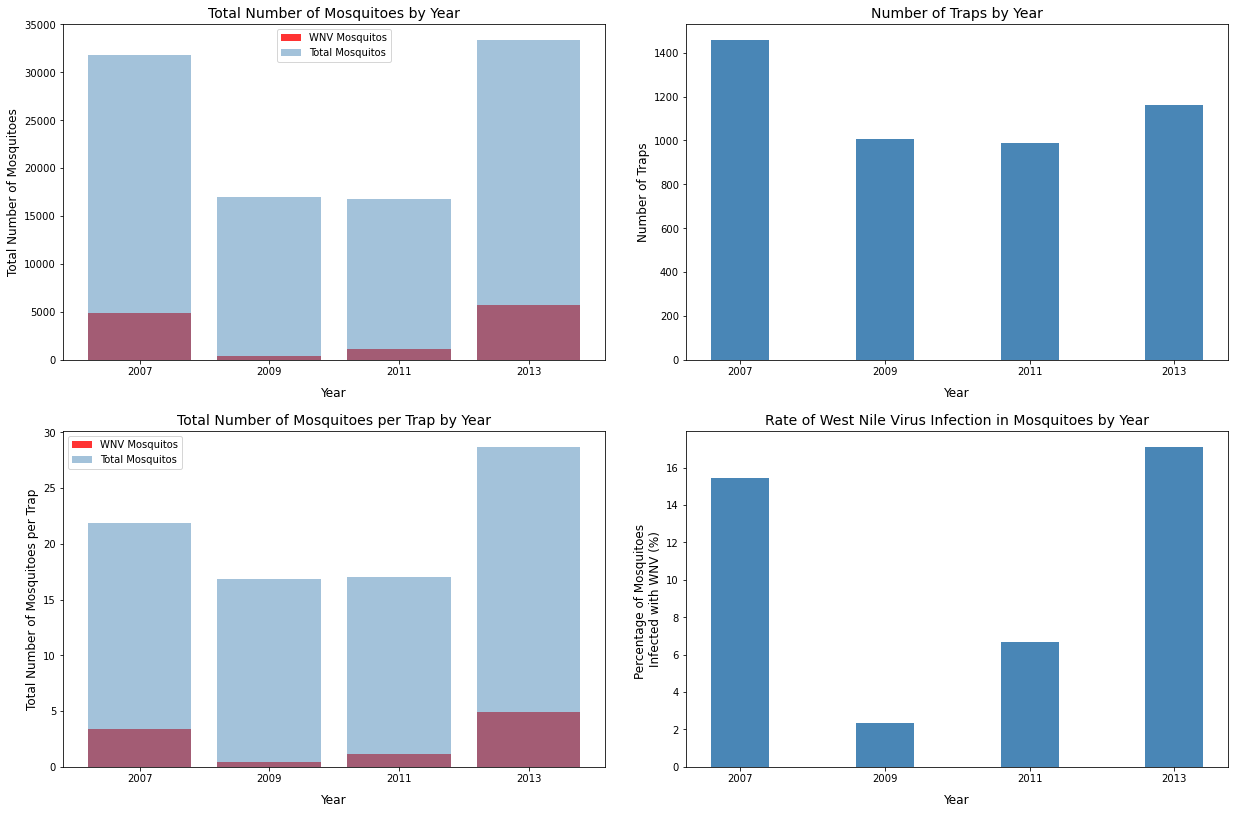

In [15]:
timewise_trender(
    time_period='year',
    list_xticklabels=['2007', '2009', '2011', '2013',],
)


- We can note that there is an imbalance in sample sizes between years with the most number of tests performed/collected in 2007, followed by 2013, with 2009 and 2011 at a similar level, 2009 being slightly higher
- However, despite a similar number of tests performed/collected, and similar numbers of mosquitoes caught in 2009 (16,958) and 2011 (16,791), the rate of WNV infection in mosquitoes in 2011 (\~7.5%) was found to be more than double that of 2009 (~3%), 
- Similarly, 2013 had a lower number of traps (2323) than 2007 (3231), yet managed to detect more WNV-infected mosquitoes (~17% to ~15.8%)
- Overall, the rates of infection each year should be the same, if not slightly rising due to warmer global temperatures caused by climate change. The fact that they aren't indicates that the sampling process is inconsistent between years e.g. inconsistent timing, inconsistent testing locations

<a name=traps_month></a>

### By Month

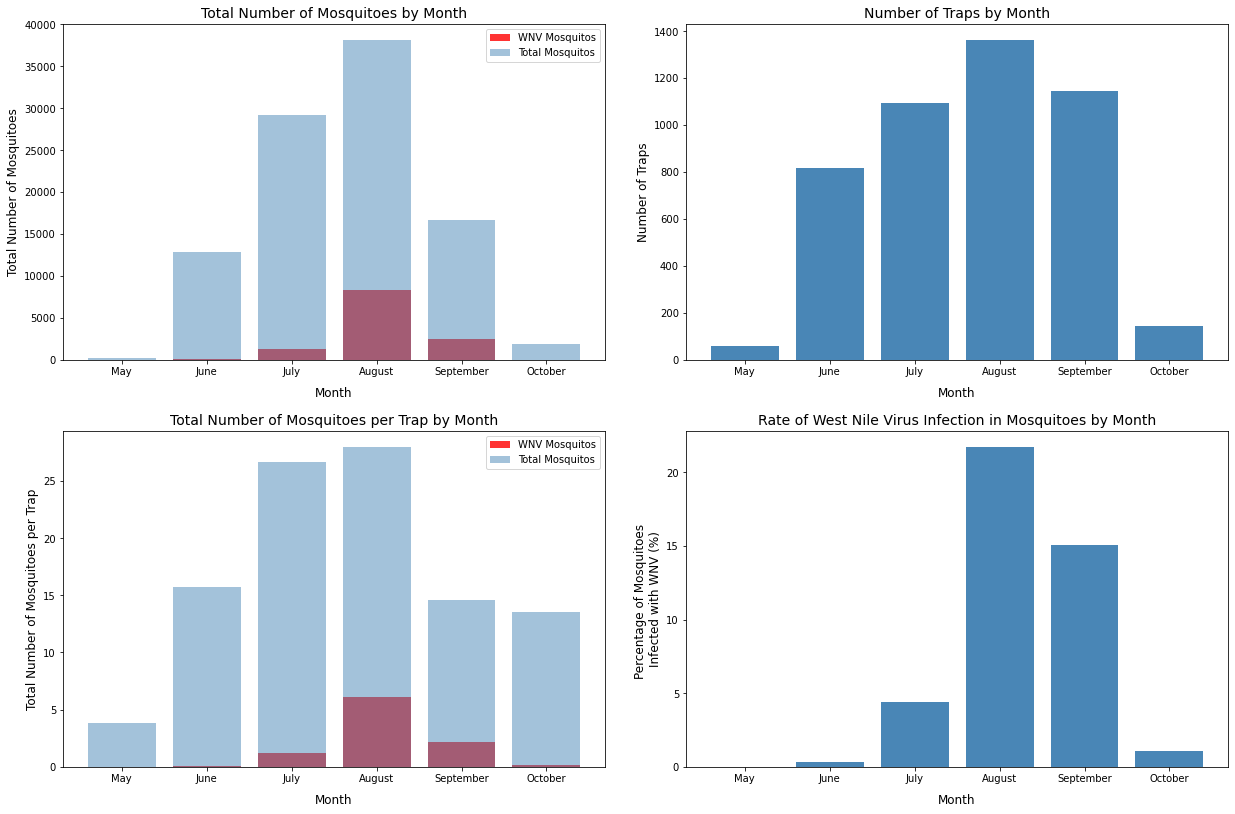

In [16]:
timewise_trender(
    time_period='month',
    list_xticklabels=['May', 'June', 'July', 'August', 'September', 'October']
)

- As before, there is also an imbalance in the sampling, with sampling only occurring between May and October with heavier emphasis on the Summer months of June to September
    - This appears to be an intended and understandable decision as the vectors for WNV (mosquitoes) are only active in warmer months, even then WNV is only present in a subset of those warm months as evidenced by May being absent of any WNV-infected mosquitoes
    - That being said, more consistent sampling would allow use to more accurately identify trends
- Based on the rates of infection by month, we can see that WNV-infection begins in June, peaks in August and, tapers off in October, possibly lasting until November 

#### By Week

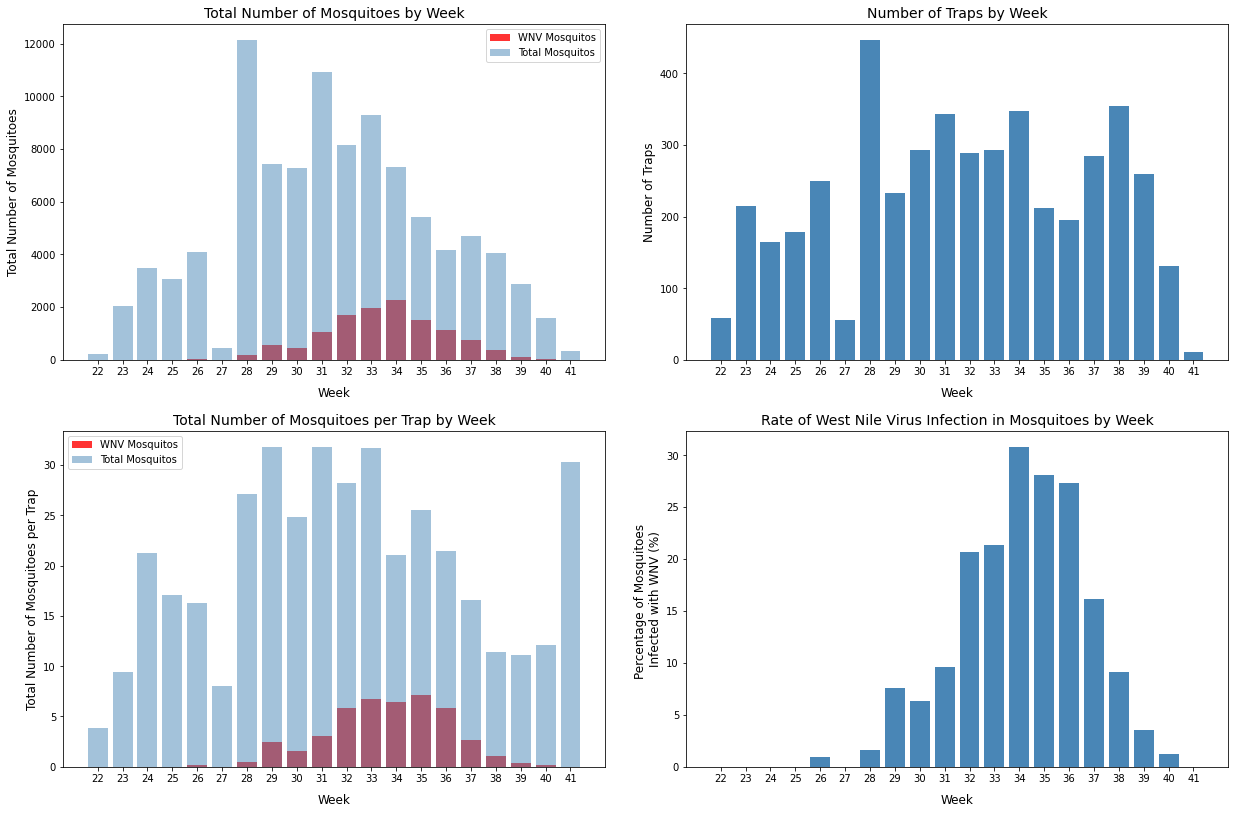

In [17]:
timewise_trender(
    time_period='week',
    list_xticklabels=[
        '22', '23', '24', '25',
        '26', '27', '28', '29',
        '30', '31', '32', '33',
        '34', '35', '36', '37',
        '38', '39', '40', '41']
)

#        '30/05\n(22)', '06/06\n(22)', '13/06\n(22)', '20/06\n(22)',
#        '27/06\n(26)', '04/06\n(27)', '11/07\n(28)', '18/07\n(29)',
#        '25/07\n(30)', '01/08\n(31)', '08/08\n(32)', '15/08\n(33)',
#        '22/08\n(34)', '29/08\n(35)', '05/09\n(36)', '12/09\n(37)',
#        '19/09\n(38)', '26/09\n(39)','03/10\n(40)', '10/10\n(41)'])

- As this is just a more detailed look into the monthly data, the sampling being imblanced is expected
- The greatest disparity when sectioning the data by week is the week (27) starting the 4th of July which is likely due to the American holiday Independence Day which meant samples remained uncollected
    - This also affected the sample collection a week later (28), causing the number of traps collected to double when compared to other weeks


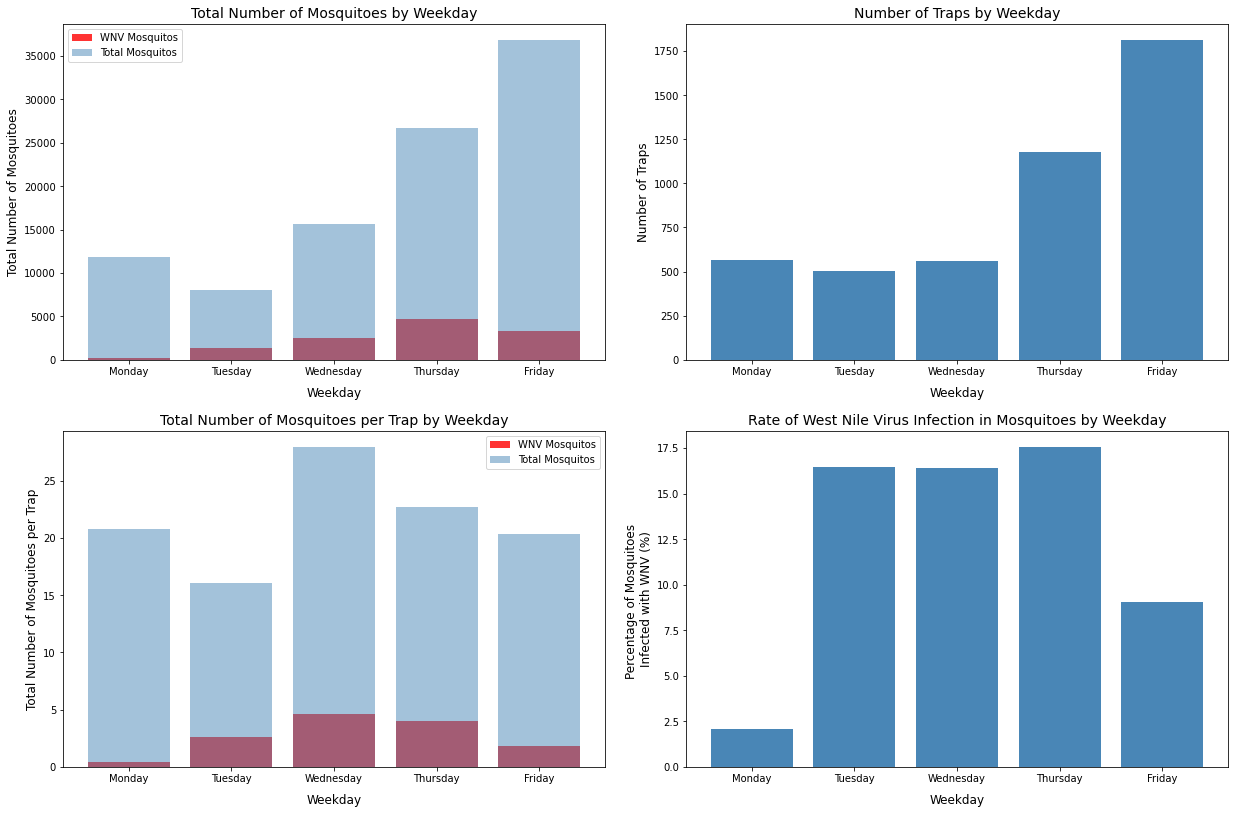

In [18]:
timewise_trender(
    'weekday', 
     ['Monday', 'Tuesday', 'Wednesday', 'Thursday', 'Friday']
)

- There is once again an imbalance in the sampling process, with the number of tests collected on Monday, Tuesday, and Wednesday being significantly lower than the number tests collected on Thursday and Friday (~50%-33% respectively).
- The rate of WNV infection is far lower on Monday than any other day. Although there is no clear reason for this, it might be due to the increase in human exposure to the mosquitoes over the weekend.
    - As most of the data is taken over the Summer, there is a higher likelihood that families would be spending the weekend outdoors as opposed to indoors for the weekdays. This would result in a greater exposure to mosquitoes over these two days. This increase in accessibility to a food source would result in fewer mosquitoes feeding on reservoir species like the American robin, and thus an overall decrease in the number of infected mosquitoes collected on Monday

## Distribution of WNV among Mosquito Species<a name=wnvspeciesdistn></a>

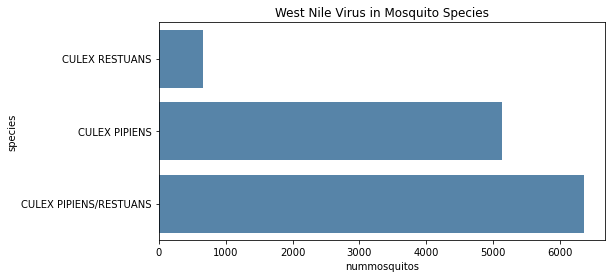

In [19]:
# Plotting the presence of West Nile Virus among different species of Mosquitoes
plt.figure(figsize=(8,4))
moz_wnv = weather_train_df[weather_train_df['wnvpresent']==1].groupby(by='species').sum().reset_index().sort_values(by='nummosquitos',ascending=True)
sns.barplot(
    data=moz_wnv, 
    x='nummosquitos', 
    y='species', 
    color='#4986B6', 
    orient='h'
)
plt.title('West Nile Virus in Mosquito Species');
plt.savefig(f'../assets/eda/wnv_mosq_species')

- From the above chart, we can see that the West Nile Virus is only present in Culex Pipiens and Culex Restuans, Culex Pipiens/Restuans being the assigned name to mosquitoes that were unable to be definitively identified as one or the other

In [20]:
# Traps ordered by the number of WNV mosquitoes caught
weather_train_df.groupby('trap').mean().sort_values('wnv_mosqs', ascending=False).head()

,block,latitude,longitude,addressaccuracy,nummosquitos,wnvpresent,year,month,week,weekday,...,wetbulb,heat,cool,preciptotal,stnpressure,sealevel,resultspeed,resultdir,avgspeed,wnv_mosqs
trap,,,,,,,,,,,,,,,,,,,,,
T054C,21.0,41.925652,-87.633590,8.0,16.111111,0.111111,2013.000000,8.333333,34.666667,4.111111,...,64.333333,0.000000,7.666667,0.087222,29.384444,30.030000,5.288889,19.333333,7.244444,5.000000
T233,71.0,42.009876,-87.807277,9.0,14.448980,0.122449,2012.346939,7.959184,32.836735,4.183673,...,62.693878,1.918367,7.102041,0.138878,29.285102,30.002449,6.451020,19.938776,7.677551,4.714286
T143,65.0,41.999129,-87.795585,8.0,7.419355,0.193548,2007.000000,7.709677,31.645161,2.838710,...,67.387097,0.645161,10.967742,0.272903,29.228065,29.939677,5.645161,15.387097,7.145161,4.612903
T115,12.0,41.673408,-87.599862,5.0,24.377358,0.094340,2009.377358,7.735849,32.009434,3.448113,...,65.301887,0.636792,9.985849,0.085330,29.310377,29.952453,6.207075,17.495283,7.823113,3.905660
T014,64.0,41.970248,-87.787992,8.0,12.133333,0.133333,2007.000000,8.100000,33.166667,2.866667,...,65.633333,0.600000,9.633333,0.184000,29.262333,29.974333,6.256667,15.666667,7.840000,3.566667


In [21]:
# Traps ordered by the number of mosquitoes caught
weather_train_df.groupby('trap').mean().sort_values('nummosquitos', ascending=False).head()

,block,latitude,longitude,addressaccuracy,nummosquitos,wnvpresent,year,month,week,weekday,...,wetbulb,heat,cool,preciptotal,stnpressure,sealevel,resultspeed,resultdir,avgspeed,wnv_mosqs
trap,,,,,,,,,,,,,,,,,,,,,
T103,11.0,41.702724,-87.536497,5.0,29.736842,0.070175,2007.000000,8.210526,33.491228,2.964912,...,70.122807,0.157895,14.140351,0.219298,29.304386,29.941930,4.742105,14.964912,6.807018,3.035088
T115,12.0,41.673408,-87.599862,5.0,24.377358,0.094340,2009.377358,7.735849,32.009434,3.448113,...,65.301887,0.636792,9.985849,0.085330,29.310377,29.952453,6.207075,17.495283,7.823113,3.905660
T008,70.0,42.008314,-87.777921,9.0,18.792593,0.074074,2010.007407,7.451852,30.562963,3.888889,...,64.496296,0.866667,8.303704,0.275704,29.235037,29.947333,6.271111,17.688889,7.703704,2.444444
T225,82.0,41.743402,-87.731435,8.0,18.640000,0.110000,2010.880000,7.820000,32.490000,4.130000,...,63.810000,0.840000,8.080000,0.090600,29.331200,29.982700,6.051000,17.910000,7.304000,2.850000
T138,10.0,41.726465,-87.585413,5.0,18.403315,0.049724,2008.790055,7.950276,32.729282,3.441989,...,65.580110,0.812155,10.165746,0.122293,29.320552,29.961989,6.016575,18.751381,7.736464,2.259669


## Overall Rate of WNV Infection<a name=ratewnv></a>

12.3% of the mosquitoes sampled were found to have WNV.


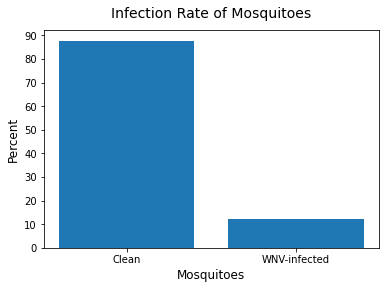

In [22]:
# charting the prevalence of WNV-infected mosquitoes
plt.bar([0,1], [(weather_train_df['nummosquitos'].sum() - weather_train_df['wnv_mosqs'].sum()) / weather_train_df['nummosquitos'].sum() *100, 
                weather_train_df['wnv_mosqs'].sum() / weather_train_df['nummosquitos'].sum() *100,])
plt.xlabel('Mosquitoes', fontsize=12)
plt.xticks(ticks=[0,1], labels=['Clean', 'WNV-infected'])
plt.ylabel('Percent',fontsize=12,)
plt.yticks(ticks=range(0, 100, 10))
plt.tick_params(labelsize=10)
plt.title('Infection Rate of Mosquitoes',fontsize=14, y=1.03)

print(f"{round(weather_train_df['wnv_mosqs'].sum() / weather_train_df['nummosquitos'].sum() *100 ,1)}% of the mosquitoes sampled were found to have WNV.")

plt.savefig(f'../assets/eda/wnv_imbalance')

<Figure size 432x288 with 0 Axes>

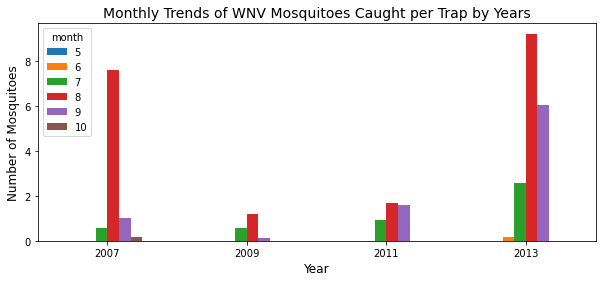

In [23]:
# plotting the monthy trend of WNV mosquitoes caught per trap by years
plt.tight_layout()

(weather_train_df.groupby(['year','month'])['wnv_mosqs'].sum().unstack() / single_samples.groupby(['year','month'])['wnvpresent'].count().unstack()).plot.bar(figsize=(10,4))
plt.title('Monthly Trends of WNV Mosquitoes Caught per Trap by Years',fontsize=14)
plt.xlabel('Year', fontsize=12)
plt.ylabel('Number of Mosquitoes', fontsize=12)
plt.xticks(rotation=0);
plt.savefig(f'../assets/eda/wnv_mosq_month_year')

- In all the years in our dataset, August and September are the months in which the most number of WNV-infected mosquitoes were detected, with July coming in a distant 3rd

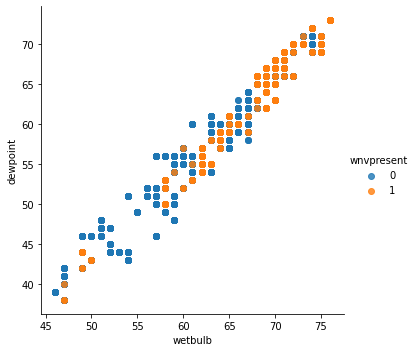

In [24]:
# plotting a regression plot along dewpoint and wetbulb features to see their relationship with the presence of WNV
sns.lmplot(data=weather_train_df, x='wetbulb', y='dewpoint', hue='wnvpresent', fit_reg=False);
plt.savefig(f'../assets/eda/dewpoint_wetbulb_wnv')

- The above chart shows us that both wetbulb and dewpoint temperatures correlate positively with the presence of WNV

- Range of WNV detection:
    - Dewpoint Temperature: 54 - 73 degrees Farenheit
    - Wetbulb Temperature: 62 - 76 degrees Farenheit

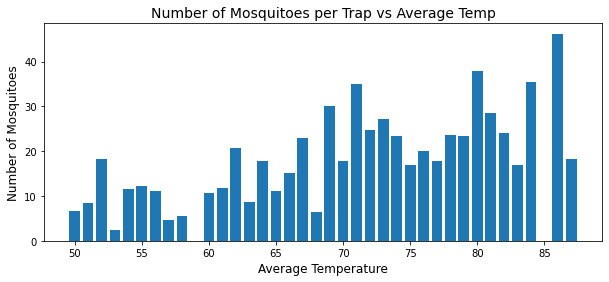

In [25]:
# plotting the average number of WNV-infected mosquitoes per trap against average temperature
plt.figure(figsize=(10,4))
plt.bar(weather_train_df.groupby('tavg')['wnv_mosqs'].sum().index,
                        weather_train_df.groupby('tavg')['nummosquitos'].sum() \
                        / single_samples.groupby('tavg')['wnv_mosqs'].count()
       )

plt.xticks(rotation=0)
plt.title('Number of Mosquitoes per Trap vs Average Temp', fontsize=14)
plt.ylabel('Number of Mosquitoes', fontsize=12)
plt.xlabel('Average Temperature', fontsize=12);
plt.savefig(f'../assets/eda/mosq_tavg')

- From the above chart, we can confirm that the number of mosquitoes  has a positive correlation with temperature
- This accounts for the number of traps, but not the location of the traps, so this data can only supply us with a vague trend

### Weather and Training Data Summary

We have discovered that the sample collection data is incredibly imbalanced, and we can break this imbalance down into 2 categories:
   - Inconsistency in sampling quantity of collection time
   - Inconsistency in sampling quantity trap locations
   
Because there is no clear consistency of these parameters across the entire dataset, we can expect our predictive model to be flawed.

## Spraying Data<a name=spray></a>
---

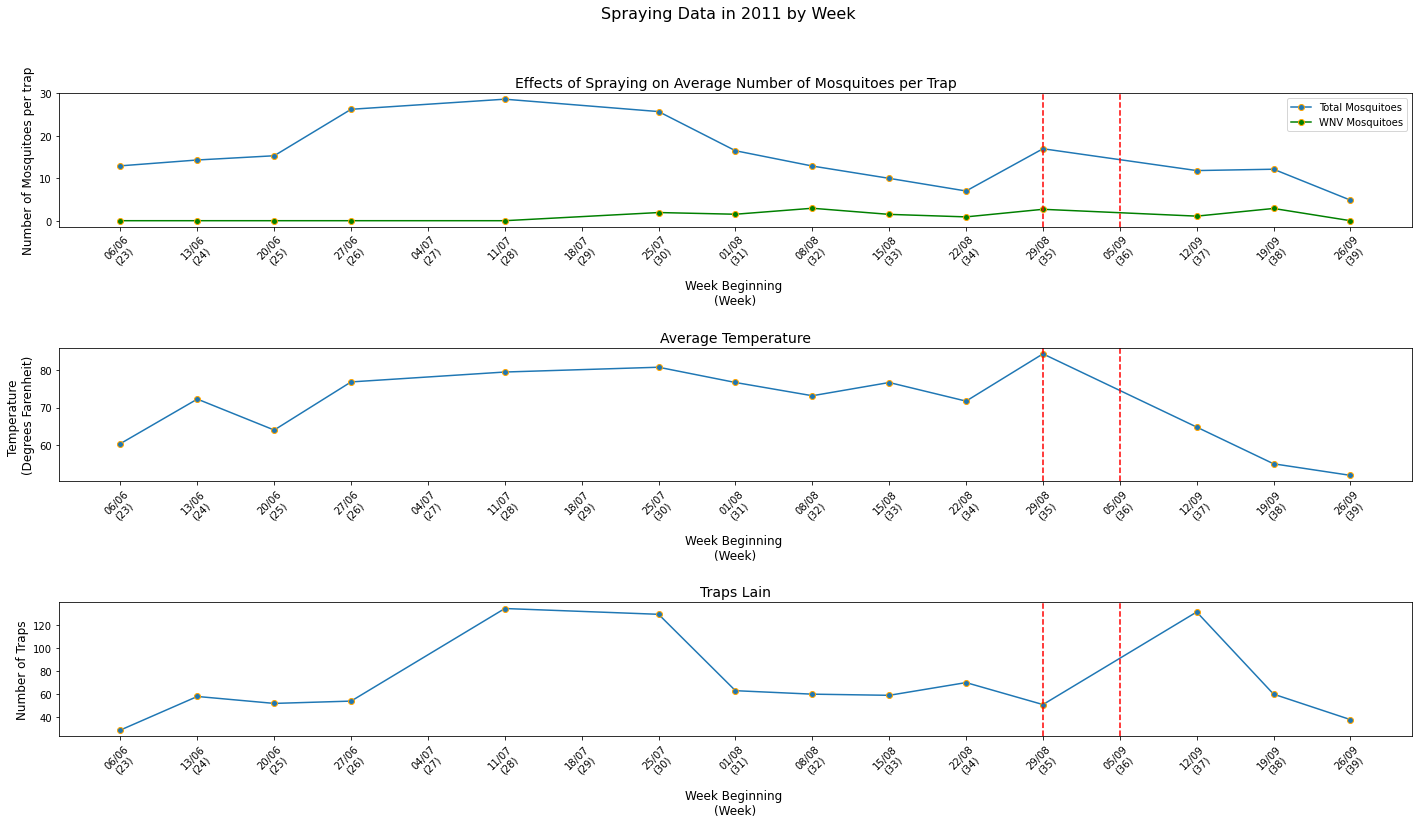

In [26]:
# plotting effects of spraying data in 2011

fig, axs = plt.subplots(3, figsize=(22,12))
fig.tight_layout(pad=10)
plt.suptitle('Spraying Data in 2011 by Week', fontsize=16)

axs[0].plot(
    weather_train_df[weather_train_df['year']==2011].groupby('week')['nummosquitos'].sum() / 
         single_samples[single_samples['year']==2011].groupby('week')['nummosquitos'].count(),
    marker='o', 
    markeredgecolor='orange',
    label='Total Mosquitoes'
)

axs[0].plot(
    weather_train_df[weather_train_df['year']==2011].groupby('week')['wnv_mosqs'].sum() / 
         single_samples[single_samples['year']==2011].groupby('week')['wnv_mosqs'].count(),
    marker='o', 
    markeredgecolor='orange',
    color='green',
    label='WNV Mosquitoes'
)
spray_dates_2011 = spray_clean[spray_clean['year']==2011]['date'].value_counts().index
for date in spray_dates_2011:
    axs[0].axvline(date.week, ls='--', color='red')

axs[0].set_title('Effects of Spraying on Average Number of Mosquitoes per Trap', fontsize=14)

axs[0].set_xlabel('Week Beginning \n(Week)', labelpad=10, fontsize=12)
axs[0].set_xticks(ticks=weather_train_df.groupby('week')['nummosquitos'].sum().index[1:-2], 
           labels=['06/06\n(23)', '13/06\n(24)', '20/06\n(25)',
                   '27/06\n(26)','04/07\n(27)', '11/07\n(28)', '18/07\n(29)',
                   '25/07\n(30)', '01/08\n(31)', '08/08\n(32)', '15/08\n(33)',
                   '22/08\n(34)', '29/08\n(35)', '05/09\n(36)', '12/09\n(37)',
                   '19/09\n(38)', '26/09\n(39)'], rotation=45)
axs[0].set_ylabel('Number of Mosquitoes per trap', fontsize=12)

axs[0].legend()

#####TEMPERATURE#####

axs[1].plot(weather_train_df[weather_train_df['year']==2011].groupby('week')['tavg'].mean(), marker='o', markeredgecolor='orange')

spray_dates_2011 = spray_clean[spray_clean['year']==2011]['date'].value_counts().index
for date in spray_dates_2011:
    axs[1].axvline(date.week, ls='--', color='red')

axs[1].set_title('Average Temperature', fontsize=14)

axs[1].set_xlabel('Week Beginning \n(Week)', labelpad=10, fontsize=12)
axs[1].set_xticks(ticks=weather_train_df.groupby('week')['nummosquitos'].sum().index[1:-2], 
           labels=['06/06\n(23)', '13/06\n(24)', '20/06\n(25)',
                   '27/06\n(26)','04/07\n(27)', '11/07\n(28)', '18/07\n(29)',
                   '25/07\n(30)', '01/08\n(31)', '08/08\n(32)', '15/08\n(33)',
                   '22/08\n(34)', '29/08\n(35)', '05/09\n(36)', '12/09\n(37)',
                   '19/09\n(38)', '26/09\n(39)'], rotation=45)
axs[1].set_ylabel('Temperature \n(Degrees Farenheit)', fontsize=12)

#####NUMBER OF TRAPS#####

axs[2].plot(single_samples[single_samples['year']==2011].groupby('week')['trap'].count(), marker='o', markeredgecolor='orange')

spray_dates_2011 = spray_clean[spray_clean['year']==2011]['date'].value_counts().index
for date in spray_dates_2011:
    axs[2].axvline(date.week, ls='--', color='red')

axs[2].set_title('Traps Lain', fontsize=14)

axs[2].set_xlabel('Week Beginning \n(Week)', labelpad=10, fontsize=12)
axs[2].set_xticks(ticks=weather_train_df.groupby('week')['nummosquitos'].sum().index[1:-2], 
           labels=['06/06\n(23)', '13/06\n(24)', '20/06\n(25)',
                   '27/06\n(26)','04/07\n(27)', '11/07\n(28)', '18/07\n(29)',
                   '25/07\n(30)', '01/08\n(31)', '08/08\n(32)', '15/08\n(33)',
                   '22/08\n(34)', '29/08\n(35)', '05/09\n(36)', '12/09\n(37)',
                   '19/09\n(38)', '26/09\n(39)'], rotation=45)
axs[2].set_ylabel('Number of Traps', fontsize=12)

plt.savefig(f'../assets/eda/spray_week_11')

- No data for weeks 27, 29, and 36
    - Day (04/07) starting week 27 was Independence Day in America, so tests were not collected. These results were ultimately collected together with week 28, causing a spike the number of mosquitoes collected that are therefore not representative of the true number
    - Day (05/09) starting week 36 was Labour Day in America. Following the same logic, the number of mosquitoes collected in week 36 is not representative of that week, and defintely lower than it shows
    - Unsure of the reason why tests were not collected for week 29. However, the same logic follows, and the number of mosquitoes collected in the following week is likely too high
- Due to inconsistent sampling and the low amounts of spraying in 2011, we will be disregarding this data in favour of the 2013 data in order to establish the effect of spraying on the numbers of mosquitoes

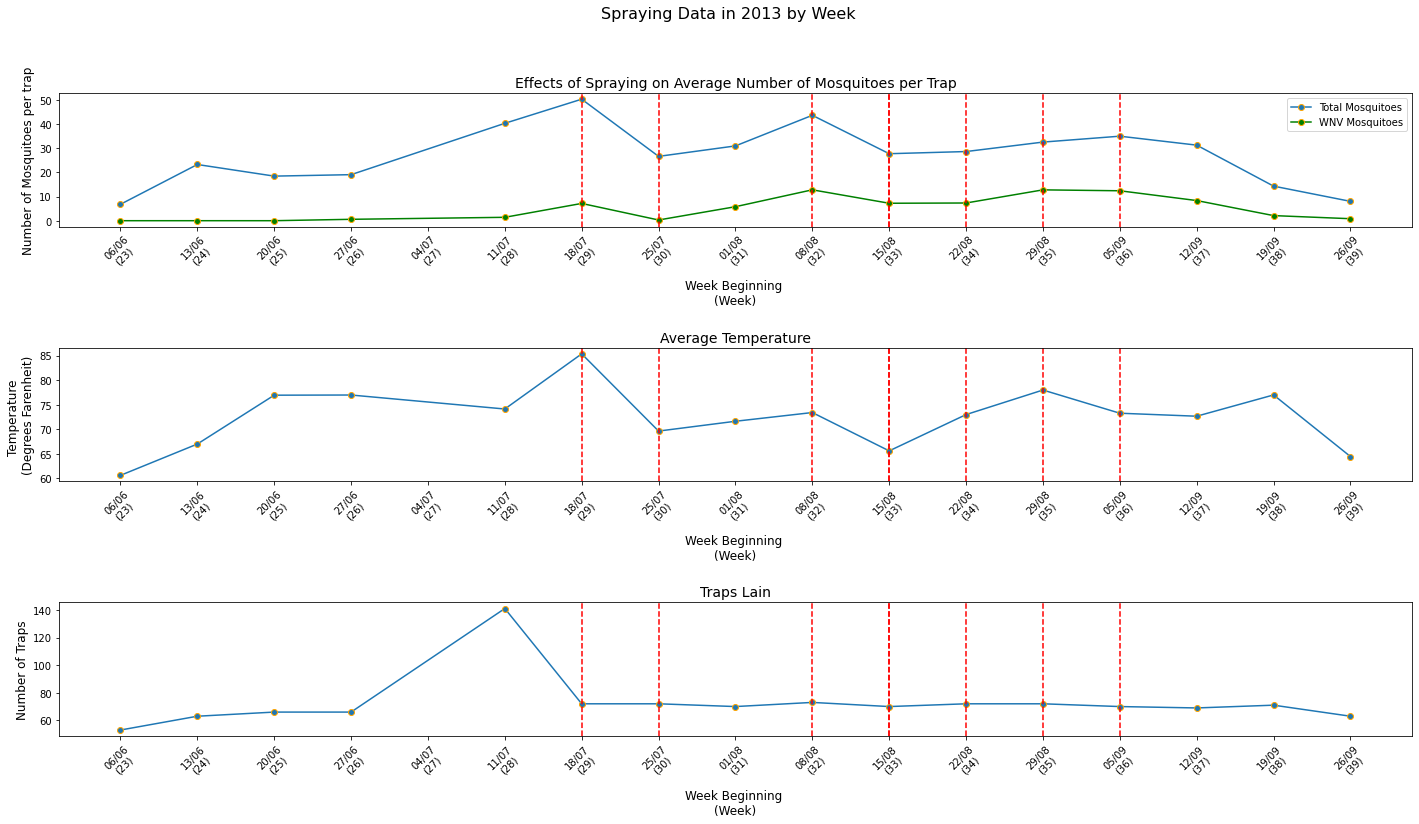

In [27]:
# plotting effects of spraying data in 2013

fig, axs = plt.subplots(3, figsize=(22,12))
fig.tight_layout(pad=10)
plt.suptitle('Spraying Data in 2013 by Week', fontsize=16)


axs[0].plot(
    weather_train_df[weather_train_df['year']==2013].groupby('week')['nummosquitos'].sum() / 
         single_samples[single_samples['year']==2013].groupby('week')['nummosquitos'].count(),
    marker='o', 
    markeredgecolor='orange',
    label='Total Mosquitoes'
)

axs[0].plot(
    weather_train_df[weather_train_df['year']==2013].groupby('week')['wnv_mosqs'].sum() / 
         single_samples[single_samples['year']==2013].groupby('week')['wnv_mosqs'].count(),
    marker='o', 
    markeredgecolor='orange',
    color='green',
    label='WNV Mosquitoes'
)
spray_dates_2013 = spray_clean[spray_clean['year']==2013]['date'].value_counts().index
for date in spray_dates_2013:
    axs[0].axvline(date.week, ls='--', color='red')

axs[0].set_title('Effects of Spraying on Average Number of Mosquitoes per Trap', fontsize=14)

axs[0].set_xlabel('Week Beginning \n(Week)', labelpad=10, fontsize=12)
axs[0].set_xticks(ticks=weather_train_df.groupby('week')['nummosquitos'].sum().index[1:-2], 
           labels=['06/06\n(23)', '13/06\n(24)', '20/06\n(25)',
                   '27/06\n(26)','04/07\n(27)', '11/07\n(28)', '18/07\n(29)',
                   '25/07\n(30)', '01/08\n(31)', '08/08\n(32)', '15/08\n(33)',
                   '22/08\n(34)', '29/08\n(35)', '05/09\n(36)', '12/09\n(37)',
                   '19/09\n(38)', '26/09\n(39)'], rotation=45)
axs[0].set_ylabel('Number of Mosquitoes per trap', fontsize=12)

axs[0].legend()

#####TEMPERATURE#####

axs[1].plot(weather_train_df[weather_train_df['year']==2013].groupby('week')['tavg'].mean(), marker='o', markeredgecolor='orange')

spray_dates_2013 = spray_clean[spray_clean['year']==2013]['date'].value_counts().index
for date in spray_dates_2013:
    axs[1].axvline(date.week, ls='--', color='red')

axs[1].set_title('Average Temperature', fontsize=14)

axs[1].set_xlabel('Week Beginning \n(Week)', labelpad=10, fontsize=12)
axs[1].set_xticks(ticks=weather_train_df.groupby('week')['nummosquitos'].sum().index[1:-2], 
           labels=['06/06\n(23)', '13/06\n(24)', '20/06\n(25)',
                   '27/06\n(26)','04/07\n(27)', '11/07\n(28)', '18/07\n(29)',
                   '25/07\n(30)', '01/08\n(31)', '08/08\n(32)', '15/08\n(33)',
                   '22/08\n(34)', '29/08\n(35)', '05/09\n(36)', '12/09\n(37)',
                   '19/09\n(38)', '26/09\n(39)'], rotation=45)
axs[1].set_ylabel('Temperature \n(Degrees Farenheit)', fontsize=12)
#####NUMBER OF TRAPS#####

axs[2].plot(single_samples[single_samples['year']==2013].groupby('week')['trap'].count(), marker='o', markeredgecolor='orange')

spray_dates_2013 = spray_clean[spray_clean['year']==2013]['date'].value_counts().index
for date in spray_dates_2013:
    axs[2].axvline(date.week, ls='--', color='red')

axs[2].set_title('Traps Lain', fontsize=14)

axs[2].set_xlabel('Week Beginning \n(Week)', labelpad=10, fontsize=12)
axs[2].set_xticks(ticks=weather_train_df.groupby('week')['nummosquitos'].sum().index[1:-2], 
           labels=['06/06\n(23)', '13/06\n(24)', '20/06\n(25)',
                   '27/06\n(26)','04/07\n(27)', '11/07\n(28)', '18/07\n(29)',
                   '25/07\n(30)', '01/08\n(31)', '08/08\n(32)', '15/08\n(33)',
                   '22/08\n(34)', '29/08\n(35)', '05/09\n(36)', '12/09\n(37)',
                   '19/09\n(38)', '26/09\n(39)'], rotation=45)
axs[2].set_ylabel('Number of Traps', fontsize=12)

plt.savefig(f'../assets/eda/spray_week_13')

- No data for week 27
    - As mentioned for the previous chart, the Day (04/07) starting week 27 is an American holiday, and likely why no tests were collected for that entire week. The results of those tests were collated with the results of the following week 28
- We can see that spraying has a strong impact on the number of mosquitoes found per trap
- Large decrease from week 32 (08/08) to week 33 (15/08), despite only 1195 locations sprayed due to an almost 10 degree drop in average temperature

## Important Traps<a name=import_traps></a>

In [28]:
# Finding the locations of the traps
pd.options.display.max_rows=10
pd.options.display.max_colwidth=100
weather_train_df[weather_train_df['trap']=='T096']['address']

19      2200 West 89th Street, Chicago, IL 60643, USA
20      2200 West 89th Street, Chicago, IL 60643, USA
63      2200 West 89th Street, Chicago, IL 60643, USA
64      2200 West 89th Street, Chicago, IL 60643, USA
65      2200 West 89th Street, Chicago, IL 60643, USA
                            ...                      
2899    2200 West 89th Street, Chicago, IL 60643, USA
2900    2200 West 89th Street, Chicago, IL 60643, USA
2901    2200 West 89th Street, Chicago, IL 60643, USA
3087    2200 West 89th Street, Chicago, IL 60643, USA
3088    2200 West 89th Street, Chicago, IL 60643, USA
Name: address, Length: 50, dtype: object

In [29]:
def trap_detailer(trap_series):
    """
    This function takes in a panda series object with trap names as the index and a float value corresponding 
    to either the average number of mosquitoes caught per trap or the average percentage of mosquitoes caught per trap
    and returns a dataframe of details for the traps, the details are as follows:
    - Trap Number: Number of the trap
    - Address: Address of the trap
    - Number of traps: Number of traps that were placed that year
    - Average Number of Mosquitoes Caught Per Trap: The average number of mosquitoes caught in each trap
    - Average Rate of WNV per trap (%): The average rate of WNV in each trap
    """
    df = pd.DataFrame(columns=['Trap Number', 
                               'Address', 
                               'Number of Traps', 
                               'Average Number of Mosquitoes Caught Per Trap', 
                               'Average Rate of WNV per trap (%)'], 
                     index=range(10))
    for i, trap in enumerate(trap_series.index):
        df.iloc[i] = pd.Series({'Trap Number':trap, 
                                'Address':weather_train_df[weather_train_df['trap']==trap]['address'], 
                                'Number of Traps':single_samples[(single_samples['year']==2013) & (single_samples['trap']==trap)]['trap'].count(), 
                                'Average Number of \nMosquitoes Caught Per Trap':round(trap_series.values[i],1),
                                'Average Rate of WNV per trap (%)':round(trap_series.values[i] * 100,2)})
    return df

In [30]:
def trap_plotter(trap_series):
    """
    This function takes in a panda series object with trap names as the index and a float value corresponding 
    to either the average number of mosquitoes caught per trap or the average percentage of mosquitoes caught per trap
    and returns a map of chicago with the areas sprayed in orange and the traps marked by blue crosses
    """
    # Plotting spray, traps, and WNV mosquitoes in 2013
    mapdata = np.loadtxt("../data/mapdata_copyright_openstreetmap_contributors.txt")
    aspect = mapdata.shape[0] * 1.0 / mapdata.shape[1]

    lon_lat_box = (-88, -87.5, 41.6, 42.1)
    plt.figure(figsize=(6,9))
    plt.imshow(mapdata,
               cmap=plt.get_cmap('GnBu_r'),
               extent=lon_lat_box,
               aspect=aspect)

    # extracting 2011 spray data
    sprays = spray_clean[spray_clean['longitude']>-88]
    spray_11 = sprays[sprays["year"]== 2013]
    spray_11_values = spray_11[['longitude', 'latitude']].drop_duplicates().values

    #plot
    plt.scatter(spray_11_values[:,0], spray_11_values[:,1], c='orange', alpha=1, label="Spray")
    for i, trap in enumerate(trap_series.index):
        trap_long = weather_train_df[weather_train_df['trap'] == trap]['longitude'].mode()
        trap_lat = weather_train_df[weather_train_df['trap'] == trap]['latitude'].mode()
        plt.scatter(trap_long, trap_lat, s = 100, marker='x', c='b')
        plt.annotate(trap, (trap_long, trap_lat))
    plt.scatter(trap_long, trap_lat, s = 100, marker='x', c='b', label='Trap')

    plt.legend();

### Traps with the Highest Numbers of Mosquitoes

In [31]:
# looking at which traps caught the most mosquitoes in 2013
highest_mosqs_trap = (weather_train_df[weather_train_df['year']==2013].groupby('trap').sum()['nummosquitos'] / 
                      single_samples[single_samples['year']==2013].groupby('trap')['wnv_mosqs'].count()).sort_values(ascending=False).nlargest(10)
highest_mosqs_trap

trap
T900    259.411765
T030     67.941176
T002     67.176471
T008     66.705882
T115     63.764706
T009     57.941176
T158     55.529412
T227     53.705882
T225     51.250000
T221     45.875000
dtype: float64

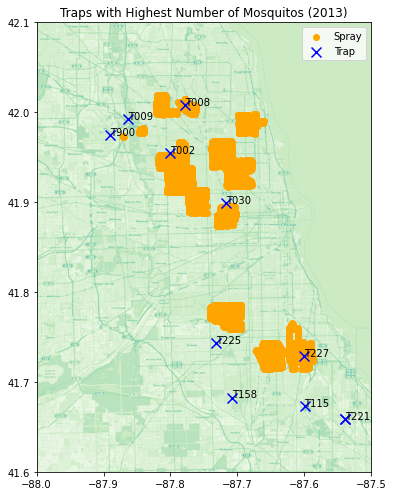

In [32]:
trap_plotter(highest_mosqs_trap)

plt.title('Traps with Highest Number of Mosquitos (2013)')

plt.savefig(f'../assets/eda/mosq_trap')

In [33]:
# Details of traps
trap_detailer(highest_mosqs_trap).drop(columns='Average Rate of WNV per trap (%)')

,Trap Number,Address,Number of Traps,Average Number of Mosquitoes Caught Per Trap
0,T900,"3245 ORD Terminal 5, O'Hare International Airport, Chicago, IL 60666, USA 3246 ORD Termina...",17,259.4
1,T030,"195 1000 North Central Park Avenue, Chicago, IL 60651, USA 196 1000 North Central Park A...",17,67.9
2,T002,"0 4100 North Oak Park Avenue, Chicago, IL 60634, USA 1 4100 North Oak Park Avenue, C...",17,67.2
3,T008,"114 7000 North Moselle Avenue, Chicago, IL 60646, USA 222 7000 North Moselle Avenue, Chi...",17,66.7
4,T115,"524 South Doty Avenue, Chicago, IL, USA 588 South Doty Avenue, Chicago, IL, USA 589 ...",17,63.8
5,T009,"32 9100 West Higgins Avenue, Chicago, IL 60656, USA 206 9100 West Higgins Avenue, Chica...",17,57.9
6,T158,"82 3500 West 116th Street, Chicago, IL 60655, USA 83 3500 West 116th Street, Chicago, ...",17,55.5
7,T227,"4233 East 91st Place, Chicago, IL, USA 4371 East 91st Place, Chicago, IL, USA 4372 East...",17,53.7
8,T225,"4230 8200 South Kostner Avenue, Chicago, IL 60652, USA 4231 8200 South Kostner Avenue, Chi...",16,51.2
9,T221,"1820 4000 East 130th Street, Chicago, IL 60633, USA 1821 4000 East 130th Street, Chicago, ...",16,45.9


- Trap T900 has caught the highest average number of mosquitoes, almost 4 times that of the next best-performing trap
- One conceivable reason this could be would be that the large amount of human traffic allows for easier feasting and breeding for mosquitoes to prosper
- Not just human traffic, but there could also be other more easily accessible sources of food for mosquitoes e.g. birds, wild animals
- Another possibility could be that there are more stangnant water bodies at the airfield e.g. puddles, ditches that are perfect breeding grounds for mosquitoes
- T900 appears to be outside of the spraying area, which is extremely strange considering the importance of this location as for mosquito control

### Traps with the Highest Number of WNV-infected Mosquitoes

In [34]:
# looking at which traps caught the most WNV-infected mosquitoes in 2013
highest_wnv_mosqs_trap = (weather_train_df[weather_train_df['year']==2013].groupby('trap').sum()['wnv_mosqs'] / 
                          single_samples[single_samples['year']==2013].groupby('trap')['wnv_mosqs'].count()).sort_values(ascending=False).nlargest(10)
highest_wnv_mosqs_trap

trap
T900    68.529412
T030    18.411765
T013    15.823529
T002    14.470588
T233    13.588235
T225    13.500000
T115    10.941176
T054    10.411765
T003    10.062500
T008     9.941176
Name: wnv_mosqs, dtype: float64

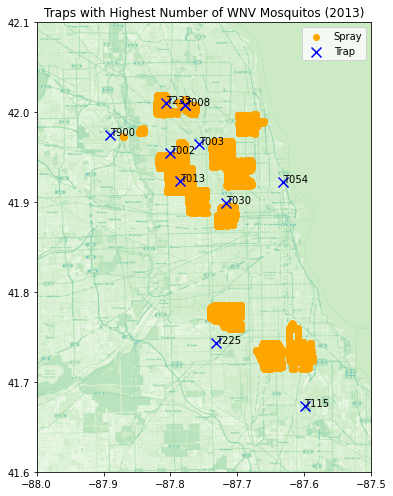

In [35]:
trap_plotter(highest_wnv_mosqs_trap)

plt.title('Traps with Highest Number of WNV Mosquitos (2013)')

plt.savefig(f'../assets/eda/wnv_mosq_trap')

In [36]:
# Details of traps
trap_detailer(highest_wnv_mosqs_trap).drop(columns='Average Rate of WNV per trap (%)').rename(columns={"Average Number of Mosquitoes Caught Per Trap":"Average Number of WNV Mosquitoes Caught Per Trap"})

,Trap Number,Address,Number of Traps,Average Number of WNV Mosquitoes Caught Per Trap
0,T900,"3245 ORD Terminal 5, O'Hare International Airport, Chicago, IL 60666, USA 3246 ORD Termina...",17,68.5
1,T030,"195 1000 North Central Park Avenue, Chicago, IL 60651, USA 196 1000 North Central Park A...",17,18.4
2,T013,"172 6100 West Fullerton Avenue, Chicago, IL 60639, USA 227 6100 West Fullerton Avenue, C...",17,15.8
3,T002,"0 4100 North Oak Park Avenue, Chicago, IL 60634, USA 1 4100 North Oak Park Avenue, C...",17,14.5
4,T233,"6518 7100 North Harlem Avenue, Chicago, IL 60631, USA 6519 7100 North Harlem Avenue, Chica...",17,13.6
5,T225,"4230 8200 South Kostner Avenue, Chicago, IL 60652, USA 4231 8200 South Kostner Avenue, Chi...",16,13.5
6,T115,"524 South Doty Avenue, Chicago, IL, USA 588 South Doty Avenue, Chicago, IL, USA 589 ...",17,10.9
7,T054,"13 2200 North Cannon Drive, Chicago, IL 60614, USA 14 2200 North Cannon Drive, Chicago...",17,10.4
8,T003,"111 4600 Milwaukee Avenue, Chicago, IL 60630, USA 220 4600 Milwaukee Avenue, Chicago, IL...",16,10.1
9,T008,"114 7000 North Moselle Avenue, Chicago, IL 60646, USA 222 7000 North Moselle Avenue, Chi...",17,9.9


- Once again, trap T900 has caught the highest average number of WNV mosquitoes, almost 4 times that of the next best-performing trap
- Likely just a reflection of the high volume of total mosquitoes caught at this trap

### Traps with the Highest Percentage of WNV-infected Mosquitoes

In [37]:
# Looking at which traps had the highest rates of WNV on average in 2013
highest_wnv_perc_trap = (weather_train_df[weather_train_df['year']==2013].groupby('trap')['wnv_mosqs'].sum() \
                        / weather_train_df[weather_train_df['year']==2013].groupby('trap')['nummosquitos'].sum() \
                        / single_samples[single_samples['year']==2013].groupby('trap')['wnv_mosqs'].count()).sort_values(ascending=False).nlargest(10)
highest_wnv_perc_trap

trap
T054C    0.044335
T147     0.030204
T054     0.025210
T003     0.024724
T013     0.024609
T235     0.022310
T233     0.022095
T220     0.021557
T223     0.020422
T028     0.017254
dtype: float64

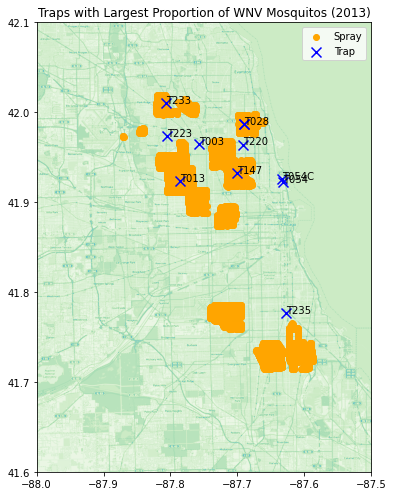

In [38]:
trap_plotter(highest_wnv_perc_trap)

plt.title('Traps with Largest Proportion of WNV Mosquitos (2013)')

plt.savefig(f'../assets/eda/wnv_rate_trap')

In [39]:
# Details of traps
trap_detailer(highest_wnv_perc_trap).drop(columns='Average Number of Mosquitoes Caught Per Trap')

,Trap Number,Address,Number of Traps,Average Rate of WNV per trap (%)
0,T054C,"8750 2100 North Cannon Drive, Chicago, IL 60614, USA 8905 2100 North Cannon Drive, Chicago...",7,4.43
1,T147,"79 2800 North Francisco Avenue, Chicago, IL 60618, USA 139 2800 North Francisco Avenue,...",14,3.02
2,T054,"13 2200 North Cannon Drive, Chicago, IL 60614, USA 14 2200 North Cannon Drive, Chicago...",17,2.52
3,T003,"111 4600 Milwaukee Avenue, Chicago, IL 60630, USA 220 4600 Milwaukee Avenue, Chicago, IL...",16,2.47
4,T013,"172 6100 West Fullerton Avenue, Chicago, IL 60639, USA 227 6100 West Fullerton Avenue, C...",17,2.46
5,T235,"5533 4200 West 65th Street, Chicago, IL 60621, USA 5622 4200 West 65th Street, Chicago, IL...",16,2.23
6,T233,"6518 7100 North Harlem Avenue, Chicago, IL 60631, USA 6519 7100 North Harlem Avenue, Chica...",17,2.21
7,T220,"49 4500 North Campbell Avenue, Chicago, IL 60625, USA 109 4500 North Campbell Avenue, C...",15,2.16
8,T223,"4124 5100 North Mont Clare Avenue, Chicago, IL 60656, USA 4270 5100 North Mont Clare Avenu...",17,2.04
9,T028,"36 5800 North Western Avenue, Chicago, IL 60659, USA 100 5800 North Western Avenue, Chi...",15,1.73


- The trap with the highest average rate of WNV is a satellite trap of the trap with the 3rd highest average rate of WNV. Their average would still place them as first
    - This location is close by to a harbour and a zoo with plenty of ponds; ideal breeding grounds for mosquitoes
- These traps would likely indicate locations with more reservoir species. It appears to be more concentrated around urban areas compared to the traps with the highest number of mosquitoes caught

In [40]:
# Number of locations sprayed at each event of spraying
spray_clean['date'].value_counts().sort_index()

2011-08-29      95
2011-09-07    1573
2013-07-17    2202
2013-07-25    1607
2013-08-08    1195
2013-08-15    2668
2013-08-16     141
2013-08-22    1587
2013-08-29    2302
2013-09-05     924
Name: date, dtype: int64

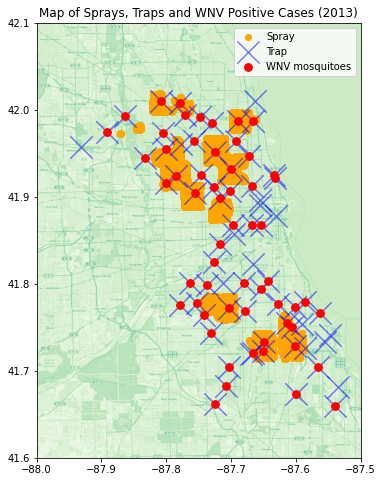

In [41]:
# Plotting spray, traps, and WNV mosquitoes in 2013
mapdata = np.loadtxt("../data/mapdata_copyright_openstreetmap_contributors.txt")
aspect = mapdata.shape[0] * 1.0 / mapdata.shape[1]

lon_lat_box = (-88, -87.5, 41.6, 42.1)
plt.figure(figsize=(8,8))
plt.imshow(mapdata,
           cmap=plt.get_cmap('GnBu_r'),
           extent=lon_lat_box,
           aspect=aspect)

# get 2013 trap data
traps = weather_train_df[['date', 'trap','longitude', 'latitude', 'wnvpresent']]
traps_13 = traps[traps["date"].dt.year == 2013]
trap_values = traps_13[['longitude', 'latitude']].drop_duplicates().values

#get 2013 spray data
sprays = spray_clean[spray_clean['longitude']>-88]
spray_13 = sprays[sprays["year"]== 2013]
spray_13_values = spray_13[['longitude', 'latitude']].drop_duplicates().values

#get 2013 wnv data
wnvpresent_13 = traps[(traps['wnvpresent'] == 1) & (traps["date"].dt.year == 2013)]
wnvpresent_values = wnvpresent_13[['longitude', 'latitude']].drop_duplicates().values

#plot
plt.scatter(spray_13_values[:,0], spray_13_values[:,1], c='orange', alpha=1, label="Spray")
plt.scatter(trap_values[:,0], trap_values[:,1], s = 500, c='blue',marker='x',label='Trap', alpha = 0.5)
plt.scatter(wnvpresent_values[:,0], wnvpresent_values[:,1], s = 60, c='r', marker='o', label='WNV mosquitoes')

plt.title('Map of Sprays, Traps and WNV Positive Cases (2013)')
plt.legend();

plt.savefig(f'../assets/eda/spray_trap')
#alot more spray done in 2013 than 2011. 
#is this effective? have to look at effectiveness of sprays broken down by month

- As we can see from the above charts, while the spraying done in 2013 did manage to cover some West Nile Virus hotspots, there were still plenty that were left unaffected
- Location-wise, the areas chosen to be sprayed could have been improved, with some areas with high number of infected mosquitoes left completely unvisited

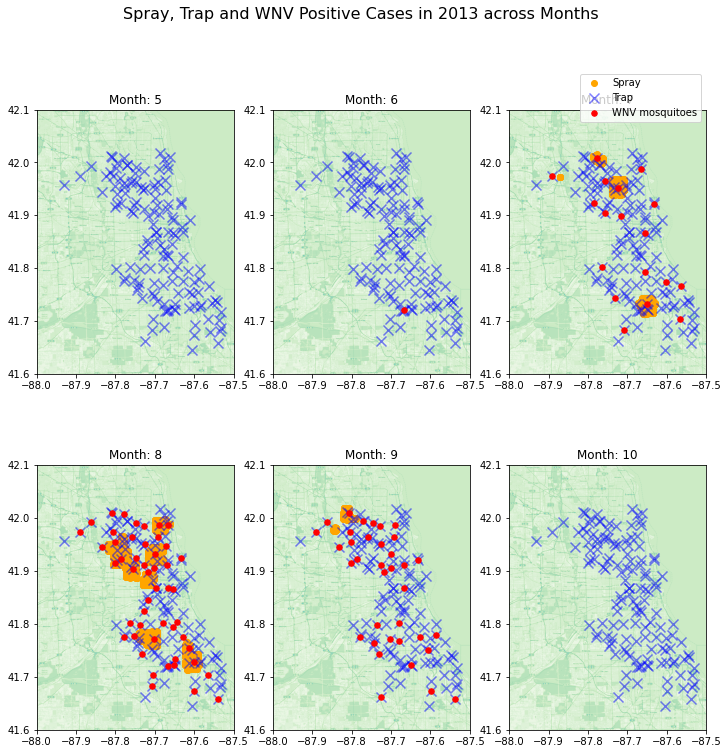

In [42]:
# Plotting spray, traps, and WNV mosquitoes in 2013 over months

#load map data
mapdata = np.loadtxt("../data/mapdata_copyright_openstreetmap_contributors.txt")
aspect = mapdata.shape[0] * 1.0 / mapdata.shape[1]
lon_lat_box = (-88, -87.5, 41.6, 42.1)

fig,ax = plt.subplots(ncols = int(weather_train_df['month'].unique().shape[0]/2), nrows = 2, figsize=(12,12))

ax = ax.ravel()

for i, month in enumerate(weather_train_df['month'].unique()):
    
    ax[i].imshow(mapdata, cmap=plt.get_cmap('GnBu_r'), extent=lon_lat_box, aspect=aspect)

    #traps data
    locations = traps[['longitude', 'latitude']].drop_duplicates().values

    #2013 spray data
    spray = spray_clean[spray_clean['longitude']>-88]
    spray_13_month = spray_clean[(spray_clean["year"]== 2013) & (spray["month"] == month)]
    sprays = spray_13_month[['longitude', 'latitude']].drop_duplicates().values

    #2013 wnvpresent data
    wnvpresent_13_month = traps[(traps['wnvpresent'] == 1) & (traps["date"].dt.year == 2013) & (traps["date"].dt.month == month)]
    wnvpresents = wnvpresent_13_month[['longitude', 'latitude']].drop_duplicates().values

    ax[i].scatter(sprays[:,0], sprays[:,1], c='orange', alpha=1, label="Spray")
    ax[i].scatter(locations[:,0], locations[:,1], s = 100, c='blue',marker='x',label='Trap',alpha=0.5)
    ax[i].scatter(wnvpresents[:,0], wnvpresents[:,1], s = 30, c='r', marker='o', label='WNV mosquitoes')

    ax[i].set_title(f'Month: {month}')
    
plt.suptitle('Spray, Trap and WNV Positive Cases in 2013 across Months', fontsize=16)
plt.legend(loc='upper right', bbox_to_anchor=(1, 2.5));

plt.savefig(f'../assets/eda/spray_trap_wnv_month')
# spraying ineffective as even after august spray still has lots of spots
# number of mosquitos with wnv have dropped consistently in month 10. possibly due to temperature

In [43]:
weather_train_df[weather_train_df['year']==2013].groupby('month').sum()

,block,latitude,longitude,addressaccuracy,nummosquitos,wnvpresent,year,week,weekday,station,...,wetbulb,heat,cool,preciptotal,stnpressure,sealevel,resultspeed,resultdir,avgspeed,wnv_mosqs
month,,,,,,,,,,,,,,,,,,,,,
6,16373,17829.218976,-37366.160969,3404,4305,1,857538,10499,2068,696,...,26316.0,337.0,3020.0,94.09,12458.87,12744.57,3218.8,6446,3730.8,38
7,23747,25194.363070,-52798.831156,4839,11233,24,1211826,17328,2399,1006,...,40463.0,0.0,6730.0,115.24,17641.67,18047.19,4495.6,11504,5013.5,734
8,32033,34031.894283,-71309.976124,6600,11708,135,1636569,26745,3252,1339,...,51797.0,0.0,5877.0,53.10,23860.46,24404.42,4558.5,14833,5718.7,3294
9,17981,20174.377845,-42274.500596,3870,6133,69,970266,17988,2069,809,...,30794.0,50.0,3557.0,33.86,14137.44,14461.08,2826.3,9867,3723.0,1646


- When looking at the spraying done on a month-to-month basis, it can be seen that while there was some effort to combat the worst of the West Nile Virus hotspots by spraying in August when West Nile Virus prevalence is historically at its highest, there is a notable absence of spraying done in both July and September
    - In July, although there was less than a quarter of the WNV-infected mosquitoes there were in August, the number of total mosquitoes were close to the same. By spraying earlier, this could have reduced the number of mosquitoes in August
    - In August, although there were fewer mosquitoes both infected and clean, the number of infected mosquitoes was still rather high at 1646, more than half of what it was in August
- This all being said, the timing of the application of sprays was probably as good as it could have been done considering it was within the constraints of a budget